# Quickstart: Building a GenAI powered Semantic Intelligence with Intugle

This quickstart shows you how to use Intugle’s open-source library to transform fragmented datasets into a connected semantic layer. The semantic layer captures profiling, relationships, and business meaning of your data — making it instantly usable for exploration, search, and data product creation.

**What is Semantic Intelligence?**

A semantic layer is an intelligent knowledge graph of your data. It connects tables, discovers relationships, and enriches them with business glossaries — so both data teams and business users can query with clarity, not complexity.

**Who is this for?**

*   **Data Engineers & Architects** often spend weeks manually profiling, classifying, and stitching together fragmented data assets. With Intugle, they can automate this process end-to-end, uncovering meaningful links and relationships to instantly generate a connected semantic layer.
*   **Data Analysts & Scientists** spend endless hours on data readiness and preparation before they can even start the real analysis. Intugle accelerates this by providing contextual intelligence, automatically generating SQL and reusable data products enriched with relationships and business meaning.
*   **Business Analysts & Decision Makers** are slowed down by constant dependence on technical teams for answers. Intugle removes this bottleneck by enabling natural language queries and semantic search, giving them trusted insights on demand.

**In this notebook, you will learn how to:**

- **Profile and classify data** : Analyze your data sources to understand their structure, data types, and other characteristics.
- **Discover links & relationships among data** : Reveal meaningful connections (PK & FK) across fragmented tables.
- **Generate a business glossary & enable semantic search** : Create business-friendly terms and use them to query data with context.
- **Create a semantic intelligence layer** : Build a unified model (YAML) of your data and relationships.
- **Build unified data products** : Generate reusable SQL queries powered by the semantic layer.

## 1. LLM Configuration

Before running the project, you need to configure a Large Language Model (LLM). This is used for tasks like generating business glossaries and predicting links between tables. For the semantic search feature, you will also need to set up Qdrant and provide an OpenAI API key. For detailed setup instructions, please refer to the [README.md](README.md) file.

You can configure the necessary services by setting the following environment variables:

*   `LLM_PROVIDER`: The LLM provider and model to use (e.g., `openai:gpt-3.5-turbo`). The format follows langchain's format for initializing chat models. Checkout how to specify your model [here](https://python.langchain.com/docs/integrations/chat/)
*   `API_KEY`: Your API key for the LLM provider. The exact name of the variable may vary from provider to provider (e.g., `OPENAI_API_KEY`, `ANTHROPIC_API_KEY`).
*   `QDRANT_URL`: The URL of your Qdrant instance (e.g., `http://localhost:6333`).
*   `QDRANT_API_KEY`: Your API key for the Qdrant instance, if authorization is enabled.
*   `EMBEDDING_MODEL_NAME`: The embedding model to use. The format follows LangChain's conventions for initializing embedding models (e.g., `openai:ada`, `azure_openai:ada`).
*   `OPENAI_API_KEY`: Your OpenAI API key, required if you are using an OpenAI embedding model.
*   `AZURE_OPENAI_API_KEY`, `AZURE_OPENAI_ENDPOINT`, `OPENAI_API_VERSION`: Your Azure OpenAI credentials, required if you are using an Azure OpenAI embedding model.

Here's an example of how to set these variables in your environment:

```bash
export LLM_PROVIDER="openai:gpt-3.5-turbo"
export OPENAI_API_KEY="your-openai-api-key"
```
Alternatively, you can set them in the notebook like this:

In [ ]:
import os

os.environ["LLM_PROVIDER"] = "openai:gpt-3.5-turbo"
os.environ["OPENAI_API_KEY"] = "your-openai-api-key"  # Replace with your actual key

# Semantic Search Configuration (Optional)
os.environ["QDRANT_URL"] = "http://localhost:6333"
os.environ["QDRANT_API_KEY"] = "" # if authorization is used
os.environ["EMBEDDING_MODEL_NAME"] = "openai:ada"
os.environ["OPENAI_API_KEY"] = "your-openai-api-key"

# For Azure OpenAI models
os.environ["EMBEDDING_MODEL_NAME"] = "azure_openai:ada"
os.environ["AZURE_OPENAI_API_KEY"] = "your-azure-openai-api-key"
os.environ["AZURE_OPENAI_ENDPOINT"] = "your-azure-openai-endpoint"
os.environ["OPENAI_API_VERSION"] = "your-openai-api-version"



> Currently the langchain packages for OpenAI, Anthropic and Gemini is installed by default. For additional models, make sure you have the integration packages installed. E.g. you should have langchain-deepseek installed to use a DeepSeek model. You can get these packages here: [LangChain Chat Models](https://python.langchain.com/docs/integrations/chat/)

## 2. Building the Knowledge Base

The `KnowledgeBuilder` is the entry point for building your semantic layer. It takes a dictionary of datasets as input and performs the following steps:

1.  **Data Profiling:** Calculates statistics for each column, such as distinct count, uniqueness, and completeness.
2.  **Datatype Identification:** Identifies the data type of each column (e.g., integer, string, datetime).
3.  **Key Identification:** Identifies potential primary keys.
4.  **Glossary Generation:** Generates a business glossary for each column using an LLM.
5.  **Link Prediction:** Predicts the relationships (foreign keys) between tables.

Let's start by defining the datasets we want to use. The path shown below can be a local file path or a remote URL.

In [2]:
def generate_config(table_name: str) -> str:
    """Append the base URL to the table name."""
    return {
        "path": f"https://raw.githubusercontent.com/Intugle/data-tools/refs/heads/main/sample_data/healthcare/{table_name}.csv",
        "type": "csv",
    }


table_names = [
    "allergies",
    "careplans",
    "claims",
    "claims_transactions",
    "conditions",
    "devices",
    "encounters",
    "imaging_studies",
    "immunizations",
    "medications",
    "observations",
    "organizations",
    "patients",
    "payers",
    "payer_transitions",
    "procedures",
    "providers",
    "supplies",
]

datasets = {table: generate_config(table) for table in table_names}

Now, let's use the `KnowledgeBuilder` to build our semantic layer:

> The `domain` parameter helps the LLM generate a more contextual business glossary. It specifies the industry domain that the dataset belongs to (e.g., "Healthcare", "Finance", "E-commerce").

In [3]:
from intugle import KnowledgeBuilder

# Initialize the knowledge builder
kb = KnowledgeBuilder(datasets, domain="Healthcare")

# Run the prediction
kb.build()

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/pydantic/_internal/_fields.py:198: UserWarning: Field name "schema" in "Source" shadows an attribute in parent "BaseResource"
  warnings.warn(


allergies loaded
careplans loaded
claims loaded
claims_transactions loaded
conditions loaded
devices loaded
encounters loaded
imaging_studies loaded
immunizations loaded
medications loaded
observations loaded
organizations loaded
patients loaded
payers loaded
payer_transitions loaded
procedures loaded
providers loaded
supplies loaded


/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[!] Empty column encountered for allergies ==> stop ...
100%|██████████| 15/15 [00:20<00:00,  1.37s/it]
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] careplans:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/in

Dataset 'allergies' already processed. Skipping analysis.
Dataset 'careplans' already processed. Skipping analysis.
Dataset 'claims' already processed. Skipping analysis.
Dataset 'claims_transactions' already processed. Skipping analysis.
Dataset 'conditions' already processed. Skipping analysis.
Dataset 'devices' already processed. Skipping analysis.
Dataset 'encounters' already processed. Skipping analysis.
Dataset 'imaging_studies' already processed. Skipping analysis.
Dataset 'immunizations' already processed. Skipping analysis.
Dataset 'medications' already processed. Skipping analysis.
Dataset 'observations' already processed. Skipping analysis.
Dataset 'organizations' already processed. Skipping analysis.
Dataset 'patients' already processed. Skipping analysis.
Dataset 'payers' already processed. Skipping analysis.
Dataset 'payer_transitions' already processed. Skipping analysis.
Dataset 'procedures' already processed. Skipping analysis.
Dataset 'providers' already processed. Sk

[*] allergies <==> careplans Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


No links found for this pair.

--- Comparing 'allergies' <=> 'claims' ---


[*] allergies <==> claims Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


No links found for this pair.

--- Comparing 'allergies' <=> 'claims_transactions' ---


[*] allergies <==> claims_transactions Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.15s/it]


No links found for this pair.

--- Comparing 'allergies' <=> 'conditions' ---


[*] allergies <==> conditions Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


No links found for this pair.

--- Comparing 'allergies' <=> 'devices' ---


[*] allergies <==> devices Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


No links found for this pair.

--- Comparing 'allergies' <=> 'encounters' ---


[*] allergies <==> encounters Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Found 1 potential link(s).

--- Comparing 'allergies' <=> 'imaging_studies' ---


[*] allergies <==> imaging_studies Runs:1: 100%|██████████| 1/1 [00:09<00:00,  9.78s/it]


No links found for this pair.

--- Comparing 'allergies' <=> 'immunizations' ---


[*] allergies <==> immunizations Runs:1: 100%|██████████| 1/1 [00:07<00:00,  7.33s/it]


No links found for this pair.

--- Comparing 'allergies' <=> 'medications' ---


[*] allergies <==> medications Runs:1: 100%|██████████| 1/1 [00:10<00:00, 10.54s/it]


No links found for this pair.

--- Comparing 'allergies' <=> 'observations' ---


[*] allergies <==> observations Runs:1: 100%|██████████| 1/1 [00:09<00:00,  9.84s/it]


No links found for this pair.

--- Comparing 'allergies' <=> 'organizations' ---


[*] allergies <==> organizations Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


No links found for this pair.

--- Comparing 'allergies' <=> 'patients' ---


[*] allergies <==> patients Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.60s/it]


Found 1 potential link(s).

--- Comparing 'allergies' <=> 'payers' ---


[*] allergies <==> payers Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


No links found for this pair.

--- Comparing 'allergies' <=> 'payer_transitions' ---


[*] allergies <==> payer_transitions Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


No links found for this pair.

--- Comparing 'allergies' <=> 'procedures' ---


[*] allergies <==> procedures Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.09s/it]


No links found for this pair.

--- Comparing 'allergies' <=> 'providers' ---


[*] allergies <==> providers Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


No links found for this pair.

--- Comparing 'allergies' <=> 'supplies' ---


[*] allergies <==> supplies Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


No links found for this pair.

--- Comparing 'careplans' <=> 'claims' ---


[*] careplans <==> claims Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


No links found for this pair.

--- Comparing 'careplans' <=> 'claims_transactions' ---


[*] careplans <==> claims_transactions Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


No links found for this pair.

--- Comparing 'careplans' <=> 'conditions' ---


[*] careplans <==> conditions Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Found 1 potential link(s).

--- Comparing 'careplans' <=> 'devices' ---


[*] careplans <==> devices Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.73s/it]


Found 1 potential link(s).

--- Comparing 'careplans' <=> 'encounters' ---


[*] careplans <==> encounters Runs:1: 100%|██████████| 1/1 [00:06<00:00,  6.45s/it]


Found 1 potential link(s).

--- Comparing 'careplans' <=> 'imaging_studies' ---


[*] careplans <==> imaging_studies Runs:1: 100%|██████████| 1/1 [00:09<00:00,  9.00s/it]


No links found for this pair.

--- Comparing 'careplans' <=> 'immunizations' ---


[*] careplans <==> immunizations Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.96s/it]


No links found for this pair.

--- Comparing 'careplans' <=> 'medications' ---


[*] careplans <==> medications Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.85s/it]


Found 1 potential link(s).

--- Comparing 'careplans' <=> 'observations' ---


[*] careplans <==> observations Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.28s/it]


Found 1 potential link(s).

--- Comparing 'careplans' <=> 'organizations' ---


[*] careplans <==> organizations Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


No links found for this pair.

--- Comparing 'careplans' <=> 'patients' ---


[*] careplans <==> patients Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.23s/it]


Found 1 potential link(s).

--- Comparing 'careplans' <=> 'payers' ---


[*] careplans <==> payers Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


No links found for this pair.

--- Comparing 'careplans' <=> 'payer_transitions' ---


[*] careplans <==> payer_transitions Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.19s/it]


No links found for this pair.

--- Comparing 'careplans' <=> 'procedures' ---


[*] careplans <==> procedures Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Found 1 potential link(s).

--- Comparing 'careplans' <=> 'providers' ---


[*] careplans <==> providers Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


No links found for this pair.

--- Comparing 'careplans' <=> 'supplies' ---


[*] careplans <==> supplies Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Found 1 potential link(s).

--- Comparing 'claims' <=> 'claims_transactions' ---


[*] claims <==> claims_transactions Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


Found 1 potential link(s).

--- Comparing 'claims' <=> 'conditions' ---


[*] claims <==> conditions Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


No links found for this pair.

--- Comparing 'claims' <=> 'devices' ---


[*] claims <==> devices Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


No links found for this pair.

--- Comparing 'claims' <=> 'encounters' ---


[*] claims <==> encounters Runs:1: 100%|██████████| 1/1 [00:12<00:00, 12.36s/it]


No links found for this pair.

--- Comparing 'claims' <=> 'imaging_studies' ---


[*] claims <==> imaging_studies Runs:1: 100%|██████████| 1/1 [00:14<00:00, 14.38s/it]


No links found for this pair.

--- Comparing 'claims' <=> 'immunizations' ---


[*] claims <==> immunizations Runs:1: 100%|██████████| 1/1 [00:11<00:00, 11.79s/it]


No links found for this pair.

--- Comparing 'claims' <=> 'medications' ---


[*] claims <==> medications Runs:1: 100%|██████████| 1/1 [00:09<00:00,  9.01s/it]


No links found for this pair.

--- Comparing 'claims' <=> 'observations' ---


[*] claims <==> observations Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.83s/it]


No links found for this pair.

--- Comparing 'claims' <=> 'organizations' ---


[*] claims <==> organizations Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Found 1 potential link(s).

--- Comparing 'claims' <=> 'patients' ---


[*] claims <==> patients Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


Found 1 potential link(s).

--- Comparing 'claims' <=> 'payers' ---


[*] claims <==> payers Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Found 1 potential link(s).

--- Comparing 'claims' <=> 'payer_transitions' ---


[*] claims <==> payer_transitions Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


No links found for this pair.

--- Comparing 'claims' <=> 'procedures' ---


[*] claims <==> procedures Runs:1: 100%|██████████| 1/1 [00:11<00:00, 11.74s/it]


No links found for this pair.

--- Comparing 'claims' <=> 'providers' ---


[*] claims <==> providers Runs:1: 100%|██████████| 1/1 [00:08<00:00,  8.86s/it]


Found 1 potential link(s).

--- Comparing 'claims' <=> 'supplies' ---


[*] claims <==> supplies Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.50s/it]


No links found for this pair.

--- Comparing 'claims_transactions' <=> 'conditions' ---


[*] claims_transactions <==> conditions Runs:1: 100%|██████████| 1/1 [00:12<00:00, 12.08s/it]


No links found for this pair.

--- Comparing 'claims_transactions' <=> 'devices' ---


[*] claims_transactions <==> devices Runs:1: 100%|██████████| 1/1 [00:08<00:00,  8.76s/it]


No links found for this pair.

--- Comparing 'claims_transactions' <=> 'encounters' ---


[*] claims_transactions <==> encounters Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.67s/it]


No links found for this pair.

--- Comparing 'claims_transactions' <=> 'imaging_studies' ---


[*] claims_transactions <==> imaging_studies Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.36s/it]


No links found for this pair.

--- Comparing 'claims_transactions' <=> 'immunizations' ---


[*] claims_transactions <==> immunizations Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.50s/it]


No links found for this pair.

--- Comparing 'claims_transactions' <=> 'medications' ---


[*] claims_transactions <==> medications Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


No links found for this pair.

--- Comparing 'claims_transactions' <=> 'observations' ---


[*] claims_transactions <==> observations Runs:1: 100%|██████████| 1/1 [00:17<00:00, 17.91s/it]


No links found for this pair.

--- Comparing 'claims_transactions' <=> 'organizations' ---


[*] claims_transactions <==> organizations Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


No links found for this pair.

--- Comparing 'claims_transactions' <=> 'patients' ---


[*] claims_transactions <==> patients Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


Found 1 potential link(s).

--- Comparing 'claims_transactions' <=> 'payers' ---


[*] claims_transactions <==> payers Runs:1: 100%|██████████| 1/1 [00:08<00:00,  8.77s/it]


Found 1 potential link(s).

--- Comparing 'claims_transactions' <=> 'payer_transitions' ---


[*] claims_transactions <==> payer_transitions Runs:1: 100%|██████████| 1/1 [00:10<00:00, 10.51s/it]


No links found for this pair.

--- Comparing 'claims_transactions' <=> 'procedures' ---


[*] claims_transactions <==> procedures Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.39s/it]


No links found for this pair.

--- Comparing 'claims_transactions' <=> 'providers' ---


[*] claims_transactions <==> providers Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Found 1 potential link(s).

--- Comparing 'claims_transactions' <=> 'supplies' ---


[*] claims_transactions <==> supplies Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


No links found for this pair.

--- Comparing 'conditions' <=> 'devices' ---


[*] conditions <==> devices Runs:1: 100%|██████████| 1/1 [00:06<00:00,  6.17s/it]


No links found for this pair.

--- Comparing 'conditions' <=> 'encounters' ---


[*] conditions <==> encounters Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Found 1 potential link(s).

--- Comparing 'conditions' <=> 'imaging_studies' ---


[*] conditions <==> imaging_studies Runs:1: 100%|██████████| 1/1 [00:08<00:00,  8.68s/it]


No links found for this pair.

--- Comparing 'conditions' <=> 'immunizations' ---


[*] conditions <==> immunizations Runs:1: 100%|██████████| 1/1 [00:09<00:00,  9.99s/it]


No links found for this pair.

--- Comparing 'conditions' <=> 'medications' ---


[*] conditions <==> medications Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.02s/it]


No links found for this pair.

--- Comparing 'conditions' <=> 'observations' ---


[*] conditions <==> observations Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


No links found for this pair.

--- Comparing 'conditions' <=> 'organizations' ---


[*] conditions <==> organizations Runs:1: 100%|██████████| 1/1 [00:06<00:00,  6.01s/it]


No links found for this pair.

--- Comparing 'conditions' <=> 'patients' ---


[*] conditions <==> patients Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Found 1 potential link(s).

--- Comparing 'conditions' <=> 'payers' ---


[*] conditions <==> payers Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


No links found for this pair.

--- Comparing 'conditions' <=> 'payer_transitions' ---


[*] conditions <==> payer_transitions Runs:1: 100%|██████████| 1/1 [00:08<00:00,  8.32s/it]


No links found for this pair.

--- Comparing 'conditions' <=> 'procedures' ---


[*] conditions <==> procedures Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.84s/it]


No links found for this pair.

--- Comparing 'conditions' <=> 'providers' ---


[*] conditions <==> providers Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


No links found for this pair.

--- Comparing 'conditions' <=> 'supplies' ---


[*] conditions <==> supplies Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


No links found for this pair.

--- Comparing 'devices' <=> 'encounters' ---


[*] devices <==> encounters Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Found 1 potential link(s).

--- Comparing 'devices' <=> 'imaging_studies' ---


[*] devices <==> imaging_studies Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


No links found for this pair.

--- Comparing 'devices' <=> 'immunizations' ---


[*] devices <==> immunizations Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


No links found for this pair.

--- Comparing 'devices' <=> 'medications' ---


[*] devices <==> medications Runs:1: 100%|██████████| 1/1 [00:08<00:00,  8.62s/it]


No links found for this pair.

--- Comparing 'devices' <=> 'observations' ---


[*] devices <==> observations Runs:1: 100%|██████████| 1/1 [00:15<00:00, 15.99s/it]


No links found for this pair.

--- Comparing 'devices' <=> 'organizations' ---


[*] devices <==> organizations Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


No links found for this pair.

--- Comparing 'devices' <=> 'patients' ---


[*] devices <==> patients Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


Found 1 potential link(s).

--- Comparing 'devices' <=> 'payers' ---


[*] devices <==> payers Runs:1: 100%|██████████| 1/1 [00:06<00:00,  6.17s/it]


No links found for this pair.

--- Comparing 'devices' <=> 'payer_transitions' ---


[*] devices <==> payer_transitions Runs:1: 100%|██████████| 1/1 [00:12<00:00, 12.62s/it]


No links found for this pair.

--- Comparing 'devices' <=> 'procedures' ---


[*] devices <==> procedures Runs:1: 100%|██████████| 1/1 [00:06<00:00,  6.53s/it]


No links found for this pair.

--- Comparing 'devices' <=> 'providers' ---


[*] devices <==> providers Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


No links found for this pair.

--- Comparing 'devices' <=> 'supplies' ---


[*] devices <==> supplies Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


No links found for this pair.

--- Comparing 'encounters' <=> 'imaging_studies' ---


[*] encounters <==> imaging_studies Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Found 1 potential link(s).

--- Comparing 'encounters' <=> 'immunizations' ---


[*] encounters <==> immunizations Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Found 1 potential link(s).

--- Comparing 'encounters' <=> 'medications' ---


[*] encounters <==> medications Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Found 1 potential link(s).

--- Comparing 'encounters' <=> 'observations' ---


[*] encounters <==> observations Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Found 1 potential link(s).

--- Comparing 'encounters' <=> 'organizations' ---


[*] encounters <==> organizations Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 potential link(s).

--- Comparing 'encounters' <=> 'patients' ---


[*] encounters <==> patients Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.16s/it]


Found 1 potential link(s).

--- Comparing 'encounters' <=> 'payers' ---


[*] encounters <==> payers Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


Found 1 potential link(s).

--- Comparing 'encounters' <=> 'payer_transitions' ---


[*] encounters <==> payer_transitions Runs:1: 100%|██████████| 1/1 [00:14<00:00, 14.43s/it]


No links found for this pair.

--- Comparing 'encounters' <=> 'procedures' ---


[*] encounters <==> procedures Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Found 1 potential link(s).

--- Comparing 'encounters' <=> 'providers' ---


[*] encounters <==> providers Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Found 1 potential link(s).

--- Comparing 'encounters' <=> 'supplies' ---


[*] encounters <==> supplies Runs:1: 100%|██████████| 1/1 [00:06<00:00,  6.19s/it]


Found 1 potential link(s).

--- Comparing 'imaging_studies' <=> 'immunizations' ---


[*] imaging_studies <==> immunizations Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.35s/it]


No links found for this pair.

--- Comparing 'imaging_studies' <=> 'medications' ---


[*] imaging_studies <==> medications Runs:1: 100%|██████████| 1/1 [00:10<00:00, 10.78s/it]


No links found for this pair.

--- Comparing 'imaging_studies' <=> 'observations' ---


[*] imaging_studies <==> observations Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.48s/it]


No links found for this pair.

--- Comparing 'imaging_studies' <=> 'organizations' ---


[*] imaging_studies <==> organizations Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


No links found for this pair.

--- Comparing 'imaging_studies' <=> 'patients' ---


[*] imaging_studies <==> patients Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Found 1 potential link(s).

--- Comparing 'imaging_studies' <=> 'payers' ---


[*] imaging_studies <==> payers Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


No links found for this pair.

--- Comparing 'imaging_studies' <=> 'payer_transitions' ---


[*] imaging_studies <==> payer_transitions Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


No links found for this pair.

--- Comparing 'imaging_studies' <=> 'procedures' ---


[*] imaging_studies <==> procedures Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


No links found for this pair.

--- Comparing 'imaging_studies' <=> 'providers' ---


[*] imaging_studies <==> providers Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


No links found for this pair.

--- Comparing 'imaging_studies' <=> 'supplies' ---


[*] imaging_studies <==> supplies Runs:1: 100%|██████████| 1/1 [00:06<00:00,  6.86s/it]


No links found for this pair.

--- Comparing 'immunizations' <=> 'medications' ---


[*] immunizations <==> medications Runs:1: 100%|██████████| 1/1 [00:14<00:00, 14.46s/it]


No links found for this pair.

--- Comparing 'immunizations' <=> 'observations' ---


[*] immunizations <==> observations Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


No links found for this pair.

--- Comparing 'immunizations' <=> 'organizations' ---


[*] immunizations <==> organizations Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Found 1 potential link(s).

--- Comparing 'immunizations' <=> 'patients' ---


[*] immunizations <==> patients Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.98s/it]


Found 1 potential link(s).

--- Comparing 'immunizations' <=> 'payers' ---


[*] immunizations <==> payers Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


No links found for this pair.

--- Comparing 'immunizations' <=> 'payer_transitions' ---


[*] immunizations <==> payer_transitions Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


No links found for this pair.

--- Comparing 'immunizations' <=> 'procedures' ---


[*] immunizations <==> procedures Runs:1: 100%|██████████| 1/1 [00:11<00:00, 11.15s/it]


No links found for this pair.

--- Comparing 'immunizations' <=> 'providers' ---


[*] immunizations <==> providers Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


No links found for this pair.

--- Comparing 'immunizations' <=> 'supplies' ---


[*] immunizations <==> supplies Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.95s/it]


No links found for this pair.

--- Comparing 'medications' <=> 'observations' ---


[*] medications <==> observations Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.61s/it]


No links found for this pair.

--- Comparing 'medications' <=> 'organizations' ---


[*] medications <==> organizations Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Found 1 potential link(s).

--- Comparing 'medications' <=> 'patients' ---


[*] medications <==> patients Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 potential link(s).

--- Comparing 'medications' <=> 'payers' ---


[*] medications <==> payers Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 potential link(s).

--- Comparing 'medications' <=> 'payer_transitions' ---


[*] medications <==> payer_transitions Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


No links found for this pair.

--- Comparing 'medications' <=> 'procedures' ---


[*] medications <==> procedures Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.92s/it]


No links found for this pair.

--- Comparing 'medications' <=> 'providers' ---


[*] medications <==> providers Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Found 1 potential link(s).

--- Comparing 'medications' <=> 'supplies' ---


[*] medications <==> supplies Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


No links found for this pair.

--- Comparing 'observations' <=> 'organizations' ---


[*] observations <==> organizations Runs:1: 100%|██████████| 1/1 [00:10<00:00, 10.11s/it]


No links found for this pair.

--- Comparing 'observations' <=> 'patients' ---


[*] observations <==> patients Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Found 1 potential link(s).

--- Comparing 'observations' <=> 'payers' ---


[*] observations <==> payers Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


No links found for this pair.

--- Comparing 'observations' <=> 'payer_transitions' ---


[*] observations <==> payer_transitions Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.67s/it]


No links found for this pair.

--- Comparing 'observations' <=> 'procedures' ---


[*] observations <==> procedures Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.17s/it]


No links found for this pair.

--- Comparing 'observations' <=> 'providers' ---


[*] observations <==> providers Runs:1: 100%|██████████| 1/1 [00:06<00:00,  6.87s/it]


No links found for this pair.

--- Comparing 'observations' <=> 'supplies' ---


[*] observations <==> supplies Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.12s/it]


No links found for this pair.

--- Comparing 'organizations' <=> 'patients' ---


[*] organizations <==> patients Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


No links found for this pair.

--- Comparing 'organizations' <=> 'payers' ---


[*] organizations <==> payers Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


No links found for this pair.

--- Comparing 'organizations' <=> 'payer_transitions' ---


[*] organizations <==> payer_transitions Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


No links found for this pair.

--- Comparing 'organizations' <=> 'procedures' ---


[*] organizations <==> procedures Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.03s/it]


No links found for this pair.

--- Comparing 'organizations' <=> 'providers' ---


[*] organizations <==> providers Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


Found 1 potential link(s).

--- Comparing 'organizations' <=> 'supplies' ---


[*] organizations <==> supplies Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


No links found for this pair.

--- Comparing 'patients' <=> 'payers' ---


[*] patients <==> payers Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


No links found for this pair.

--- Comparing 'patients' <=> 'payer_transitions' ---


[*] patients <==> payer_transitions Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Found 1 potential link(s).

--- Comparing 'patients' <=> 'procedures' ---


[*] patients <==> procedures Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Found 1 potential link(s).

--- Comparing 'patients' <=> 'providers' ---


[*] patients <==> providers Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


No links found for this pair.

--- Comparing 'patients' <=> 'supplies' ---


[*] patients <==> supplies Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.54s/it]


Found 1 potential link(s).

--- Comparing 'payers' <=> 'payer_transitions' ---


[*] payers <==> payer_transitions Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Found 1 potential link(s).

--- Comparing 'payers' <=> 'procedures' ---


[*] payers <==> procedures Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Found 1 potential link(s).

--- Comparing 'payers' <=> 'providers' ---


[*] payers <==> providers Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


No links found for this pair.

--- Comparing 'payers' <=> 'supplies' ---


[*] payers <==> supplies Runs:1: 100%|██████████| 1/1 [00:09<00:00,  9.14s/it]


No links found for this pair.

--- Comparing 'payer_transitions' <=> 'procedures' ---


[*] payer_transitions <==> procedures Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


No links found for this pair.

--- Comparing 'payer_transitions' <=> 'providers' ---


[*] payer_transitions <==> providers Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


No links found for this pair.

--- Comparing 'payer_transitions' <=> 'supplies' ---


[*] payer_transitions <==> supplies Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.45s/it]


No links found for this pair.

--- Comparing 'procedures' <=> 'providers' ---


[*] procedures <==> providers Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


Found 1 potential link(s).

--- Comparing 'procedures' <=> 'supplies' ---


[*] procedures <==> supplies Runs:1: 100%|██████████| 1/1 [00:10<00:00, 10.06s/it]


No links found for this pair.

--- Comparing 'providers' <=> 'supplies' ---


[*] providers <==> supplies Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


No links found for this pair.


/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/vector_store/qdrant.py:77: UserWarning: Api key is used with an insecure connection.
  self._client = AsyncQdrantClient(**self.client_config)


## 3. Accessing Enriched Metadata

Now that the knowledge base is built, you can easily access the enriched metadata for each dataset.

### Accessing a Dataset

You can access a specific dataset by its name from the `kb.datasets` dictionary:

In [4]:
allergies_dataset = kb.datasets['patients']
allergies_dataset.profiling_df


,column_name,business_name,table_name,null_count,count,distinct_count,uniqueness,completeness,sample_data,dtype_sample,ts,datatype_l1,datatype_l2,business_glossary,business_tags
0,id,id,patients,0,1163,1163,1.000000,1.000000,"[1a4f3136-4eae-dc5d-f68d-046b7a2e11ea, acbb6a4...","[217f95a3-4e10-bd5d-fb67-0cfb5e8ba075, 23d16ee...",0.004991,alphanumeric,L2OutputTypes.dimension,Serves as a unique identifier for individual p...,"[Patient Identifier, Unique Record Key, Health..."
1,birthdate,birthdate,patients,0,1163,987,0.848667,1.000000,"[1928-11-13, 1966-06-22, 2004-05-16, 1923-09-0...","[1993-12-23, 2018-09-16, 1970-09-14, 1956-10-2...",0.004395,date & time,L2OutputTypes.dimension,Indicates the date on which an individual was ...,"[Patient Demographics, Age Calculation, Health..."
2,deathdate,deathdate,patients,1000,1163,163,0.140155,0.140155,"[2001-09-05, 1966-05-07, 2010-01-13, 1955-11-2...","[2009-11-13, 2011-07-10, 1991-11-18, 2010-06-0...",0.005714,date & time,L2OutputTypes.dimension,Indicates the date and time when an individual...,"[Patient Mortality, End Of Life Date, Healthca..."
3,ssn,ssn,patients,0,1163,1163,1.000000,1.000000,"[999-52-4852, 999-95-8884, 999-31-6931, 999-37...","[999-59-7726, 999-16-7928, 999-47-2075, 999-31...",0.005779,alphanumeric,L2OutputTypes.dimension,Serves as a unique identifier for individuals ...,"[Patient Identification, Social Security Numbe..."
4,drivers,drivers,patients,215,1163,941,0.809114,0.815133,"[S99918599, S99986354, S99954622, S99943469, S...","[S99916617, S99985809, S99999275, S99929211, S...",0.003784,alphanumeric,L2OutputTypes.dimension,Unique identifiers used to associate individua...,"[Driver Identification, Healthcare Provider Re..."
5,passport,passport,patients,276,1163,887,0.762683,0.762683,"[X15711612X, X42921765X, X84876726X, X69721357...","[X75063318X, X33683613X, X77363212X, X62900787...",0.006447,alphanumeric,L2OutputTypes.dimension,Unique identifier used to document and track i...,"[Patient Identification, Travel Documentation,..."
6,prefix,prefix,patients,245,1163,3,0.002580,0.789338,"[Mr., Mrs., Ms.]","[Ms., Mr., Mrs., Mrs., Mrs., Ms., Ms., Mr., Mr...",0.003622,close_ended_text,L2OutputTypes.dimension,Indicates the title or honorific used to addre...,"[Patient Salutation, Personal Title, Demograph..."
7,first,first,patients,0,1163,1002,0.861565,1.000000,"[Elena945, Ana972, Donetta1, Chris95, Marivel8...","[Franklyn361, Bonita405, Jonathon205, Gerry91,...",0.006652,alphanumeric,L2OutputTypes.dimension,Identifies individuals using a unique alphanum...,"[Patient Identifier, Healthcare Record Trackin..."
8,last,last,patients,0,1163,477,0.410146,1.000000,"[Greenfelder433, Gerhold939, Estévez304, Hane6...","[Walter473, Herzog843, Wisoky380, Runolfsson90...",0.005493,alphanumeric,L2OutputTypes.dimension,Identifies individuals uniquely within the pat...,"[Patient Identifier, Healthcare Record Trackin..."
9,suffix,suffix,patients,1147,1163,3,0.002580,0.013758,"[JD, PhD, MD]","[JD, MD, PhD, PhD, MD, MD, PhD, PhD, JD, MD, P...",0.003334,close_ended_text,L2OutputTypes.dimension,Indicates the professional or academic designa...,"[Professional Credentials, Patient Identificat..."


The profiling results can be accessed through the `profiling_df` property of the `DataSet` object. It's a pandas DataFrame that you can easily explore. 
> The business glossary is also available in the `profiling_df`:


### Visualizing Relationships

The `KnowledgeBuilder` automatically discovers the relationships between your tables. You can access the predicted links as a list of `PredictedLink` objects:


In [5]:
kb.links

[PredictedLink(from_dataset='allergies', from_column='encounter', to_dataset='encounters', to_column='id'),
 PredictedLink(from_dataset='allergies', from_column='patient', to_dataset='patients', to_column='id'),
 PredictedLink(from_dataset='careplans', from_column='encounter', to_dataset='conditions', to_column='encounter'),
 PredictedLink(from_dataset='careplans', from_column='encounter', to_dataset='devices', to_column='encounter'),
 PredictedLink(from_dataset='careplans', from_column='encounter', to_dataset='encounters', to_column='id'),
 PredictedLink(from_dataset='careplans', from_column='encounter', to_dataset='medications', to_column='encounter'),
 PredictedLink(from_dataset='careplans', from_column='encounter', to_dataset='observations', to_column='encounter'),
 PredictedLink(from_dataset='careplans', from_column='patient', to_dataset='patients', to_column='id'),
 PredictedLink(from_dataset='careplans', from_column='encounter', to_dataset='procedures', to_column='encounter'),
 

You can also visualize these relationships as a graph:


/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/pydantic/_internal/_fields.py:198: UserWarning: Field name "schema" in "Source" shadows an attribute in parent "BaseResource"
  warnings.warn(


payer_transitions loaded
encounters loaded
careplans loaded
patients loaded
claims loaded
organizations loaded
medications loaded
providers loaded
supplies loaded
devices loaded
payers loaded
conditions loaded
observations loaded
procedures loaded
claims_transactions loaded
imaging_studies loaded
immunizations loaded
allergies loaded
top_patients_by_claim_count
top_patients_by_claim_count loaded


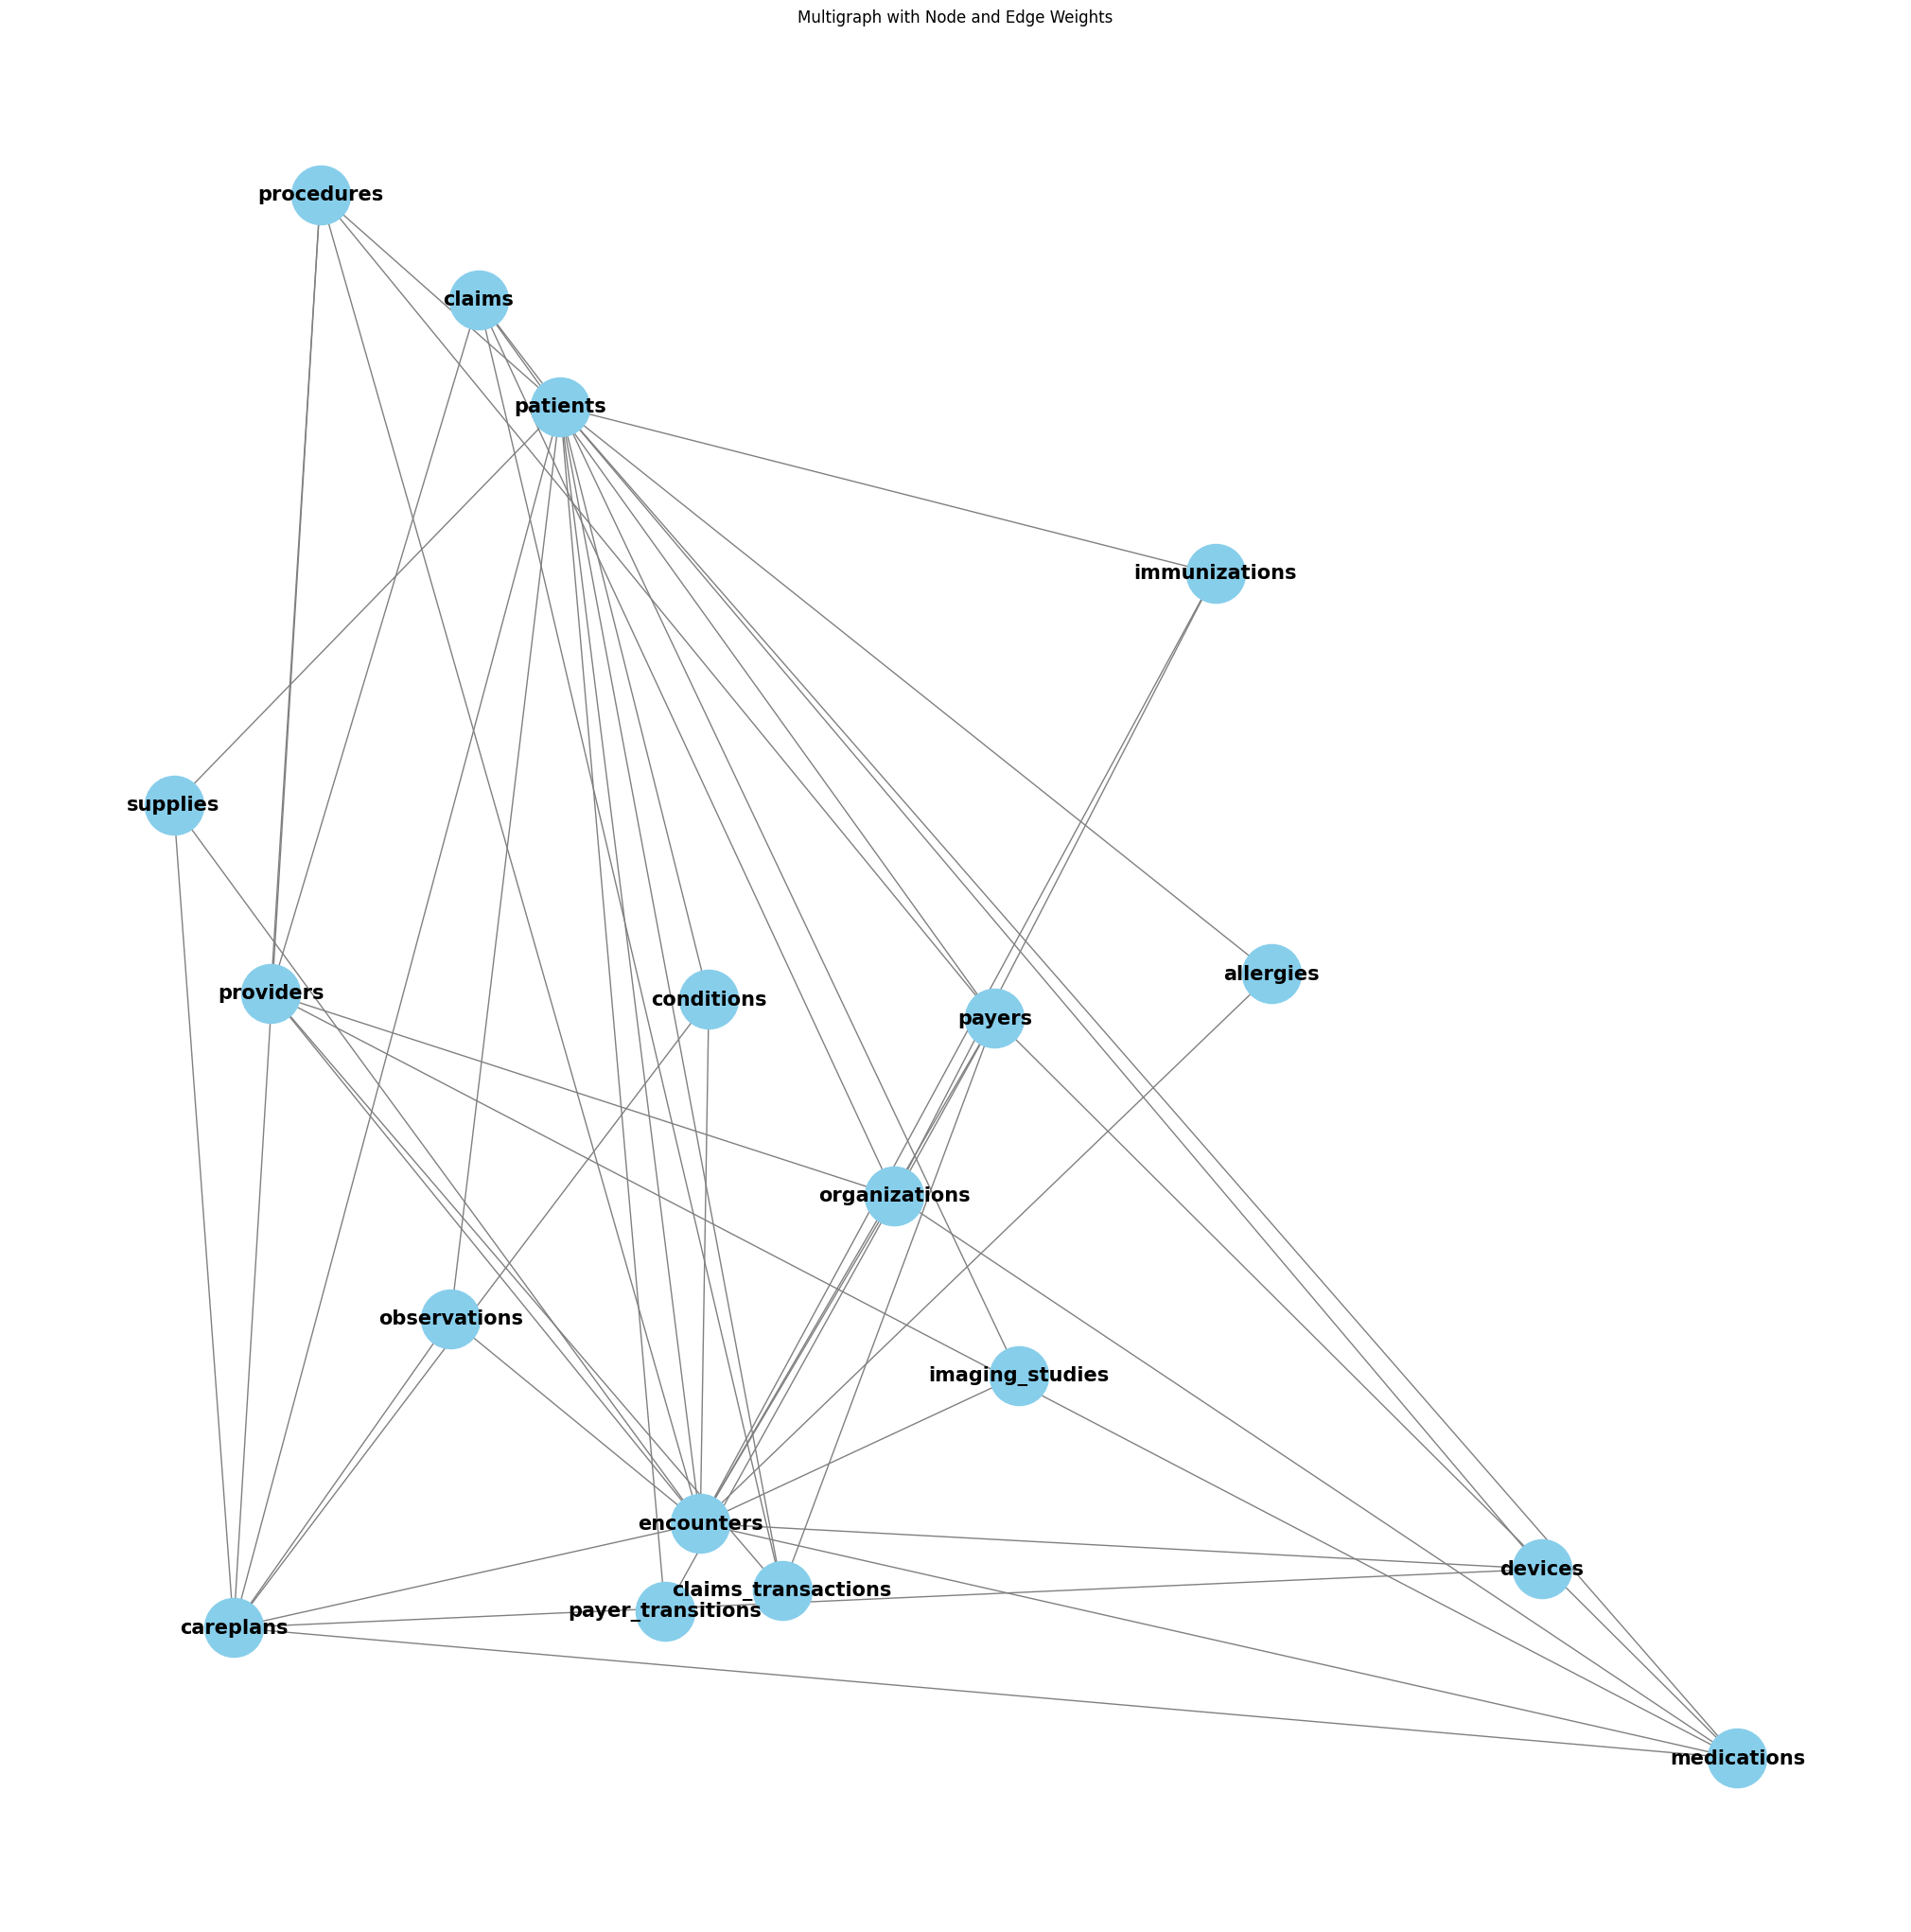

In [ ]:
kb.visualize()


## 4. The Semantic Layer

The KnowledgeBuilder results are used to generate YAML files which are saved automatically. These files defines the semantic layer, including the models (tables) and their relationships. 

By default, these files are saved in the current working directory. You can configure this path by setting the `PROJECT_BASE` environment variable.


## 5. Semantic Search

The semantic search feature allows you to search for columns in your datasets using natural language. 

> **Note:** To use this feature, you need to have a running Qdrant instance and an OpenAI API key. Please refer to the [README.md](README.md) for detailed setup instructions.

Once you have built the knowledge base, you can use the `search` method to perform a semantic search. The search function returns a pandas DataFrame containing the search results, including the column's profiling metrics, category, table name, and table glossary.


In [4]:
# Perform a semantic search
search_results = kb.search("reason for hospital visit")

# View the search results
search_results

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/vector_store/qdrant.py:77: UserWarning: Api key is used with an insecure connection.
  self._client = AsyncQdrantClient(**self.client_config)
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/vector_store/qdrant.py:77: UserWarning: Api key is used with an insecure connection.
  self._client = AsyncQdrantClient(**self.client_config)
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/semantic_search/semantic_search.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  late_embedding_result_glossary["score"] = late_embedding_result_glossary["score"] / len(late_vector)


,column_id,score,relevancy,column_name,column_glossary,column_tags,category,table_name,table_glossary,uniqueness,completeness,count,null_count,distinct_count,sample_data
0,encounters.reasoncode,0.884030,most-relevant,reasoncode,Indicates the coded reason for a specific inte...,"[Encounter Reason, Clinical Coding, Diagnosis ...",dimension,encounters,Tracks interactions between individuals and se...,0.023000,0.2865,2000,1427,46,"[6072007.0, 62106007.0, 128613002.0, 38822007...."
1,claims.diagnosis8,0.883179,most-relevant,diagnosis8,Captures the eighth recorded medical condition...,"[Medical Diagnosis Code, Healthcare Claims Pro...",dimension,claims,Tracks financial and administrative details re...,0.000500,0.0005,2000,1999,1,[840544004]
2,careplans.reasoncode,0.881082,most-relevant,reasoncode,Indicates the underlying justification or rati...,"[Care Plan Justification, Clinical Reason Code...",dimension,careplans,Defines structured plans outlining care activi...,0.031500,0.8480,2000,304,63,"[284551006, 95417003, 284549007, 62564004, 444..."
3,claims.referringproviderid,0.880542,most-relevant,referringproviderid,Identifies the professional who directed a pat...,"[Provider Referral Tracking, Healthcare Provid...",dimension,claims,Tracks financial and administrative details re...,0.000000,0.0000,2000,2000,0,[]
4,encounters.description,0.879891,most-relevant,description,Provides a concise label or category for the t...,"[Healthcare Encounter Type, Patient Interactio...",dimension,encounters,Tracks interactions between individuals and se...,0.020500,1.0000,2000,0,41,"[Screening surveillance (regime/therapy), Hosp..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,encounters.code,0.809779,relevant,code,Identifies the type or category of medical enc...,"[Encounter Classification, Healthcare Code Sta...",dimension,encounters,Tracks interactions between individuals and se...,0.016500,1.0000,2000,0,33,"[32485007, 183452005, 86013001, 702927004, 170..."
245,providers.zip,0.809742,relevant,zip,Identifies the postal code associated with the...,"[Provider Location, Geographic Identifier, Pos...",dimension,providers,Serves as a centralized registry of profession...,0.312500,1.0000,2000,0,625,"[01420, 02130, 01093, 02675-2171, 02151-3200, ..."
246,allergies.encounter,0.808249,relevant,encounter,Tracks the specific interaction or event assoc...,"[Patient Encounter, Clinical Event Tracking, H...",dimension,allergies,Tracks individual sensitivities or adverse rea...,0.225441,1.0000,794,0,179,"[c7486b80-2598-a73d-8e81-ee05a2a73479, d4f68de..."
247,procedures.description,0.807511,relevant,description,Details the type or category of medical or cli...,"[Medical Procedures, Healthcare Services, Clin...",dimension,procedures,Tracks detailed records of medical or diagnost...,0.047500,1.0000,2000,0,95,"[Sputum examination (procedure), Childbirth, S..."


## 6. Data Product Creation

The semantic layer serves as a foundation for the DataProductBuilder, which streamlines the creation of reusable data products. This allows you
to encapsulate business logic and create standardized, trustworthy data assets that can be easily shared and reused across different teams and 
applications.

Let's define the model for the data product we want to build:

In [8]:
etl = {
  "name": "top_patients_by_claim_count",
  "fields": [
    {
      "id": "patients.first",
      "name": "first_name",
    },
    {
      "id": "patients.last",
      "name": "last_name",
    },
    {
      "id": "claims.id",
      "name": "number_of_claims",
      "category": "measure",
      "measure_func": "count"
    }
  ],
  "filter": {
    "sort_by": [
      {
        "id": "claims.id",
        "alias": "number_of_claims",
        "direction": "desc"
      }
    ],
    "limit": 10
  }
}

Now, let's use the `DataProductBuilder` to generate the data product:

In [9]:
from intugle.dp_builder import DataProductBuilder

# Create a DataProductBuilder
dp_builder = DataProductBuilder()

# Generate the data product
data_product = dp_builder.build(etl)

data_product.to_df()


payer_transitions loaded
encounters loaded
careplans loaded
patients loaded
claims loaded
organizations loaded
medications loaded
providers loaded
supplies loaded
devices loaded
payers loaded
conditions loaded
observations loaded
procedures loaded
claims_transactions loaded
imaging_studies loaded
immunizations loaded
allergies loaded
top_patients_by_claim_count
top_patients_by_claim_count loaded


,first_name,last_name,number_of_claims
0,Esther279,Runolfsson901,246
1,Zelda766,Ernser583,219
2,Bonita405,Bernier607,121
3,Pei116,Williamson769,98
4,Magdalene960,Orn563,90
5,Lavinia262,Heaney114,90
6,Tommye961,Simonis280,77
7,Franklyn361,Tromp100,71
8,Terry864,King743,69
9,Alaine226,Willms744,64


The `generate_product` function returns a `DataSet` object. You can also view the generated SQL query used for creating the data product:


In [10]:
# The generated SQL query
data_product.sql_query



'SELECT "patients"."first" as first_name, "patients"."last" as last_name, count("claims"."id") as number_of_claims FROM claims LEFT JOIN patients ON "claims"."patientid" = "patients"."id" GROUP BY "patients"."first" , "patients"."last" ORDER BY number_of_claims DESC LIMIT 10'

## Conclusion

You've learned how to:

*   Configure your LLM provider and Embeddings provider.
*   Build a knowledge base using the `KnowledgeBuilder`.
*   Access enriched metadata, business glossaries and visualize the relationships between your tables.
*   Perform semantic search on your knowledge base.
*   Generate data products from the semantic layer using the `DataProductBuilder`.

This is just a starting point. This project has many other features to explore. We encourage you to try it with your own data and see how it can help you build a powerful semantic layer.